### import libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve#, plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import tree

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

plt.style.use('seaborn')

/Users/vitaly/.virtualenvs/py3.9-research/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [2]:
MODEL_VERSION = 'v1'

DATA_FOLDER = f'./data/RESULTS/{MODEL_VERSION}'
os.makedirs(DATA_FOLDER, exist_ok=True)

In [3]:
def my_filename(filename):
    return os.path.join(DATA_FOLDER, filename)

### data

In [4]:
df1_raw = pd.read_excel('./data/train_data.xlsx')

In [5]:
df2_raw = pd.read_excel('./data/test_data.xlsx')

In [6]:
d1 = df1_raw[[
    'пол', 
    'тип лечения', 
    'VAS Эстетическая потребность До лечения',
    'VAS Эстетическая потребность После лечения',
    'VAS Эстетическая потребность (дельта до-после) ',
    'VAS базовая функциональна потребность До лечения',
    'VAS базовая функциональна потребность После лечения',
    'VAS базовая функциональна потребность (дельта до-после) ',
    'IOTN эстетическая нуждаемость До лечения',
    'ICON окклюзионная нуждаемость До лечения',
    'Slavicek уточненная функциональная потребность До лечения',
    'Slavicek уточненная функциональная потребность После лечения',
    'Slavicek уточненная функциональная потребность (дельта до-после) ',
    'Helkimo функциональная нуждаемость До лечения',
    'Helkimo функциональная нуждаемость После лечения',
    'Helkimo функциональная нуждаемость (дельта до-после) ',
    '_class'
]]
d1 = d1[d1['тип лечения'] == 0].reset_index(drop=True)

cols = list(range(len(d1.columns)-1))
d1.columns = cols + ['_class']
d1['label'] = 1

In [7]:
d2 = df2_raw[[
    'Пол',
    'Хирургия',
    'NRS Эстетика до',
    'NRS Эстетика после',
    'NRS Эстетика разница',
    'NRS Функция до',
    'NRS Функция после',
    'NRS Функция разница',
    'IOTN',
    'ICON',
    'Славичек "до"',
    'Славичек "после"',
    'Славичек разница',
    'Хелкимо (до)',
    'Хелкимо "после"',
    'Хелкимо разница',
]]
d2.columns = cols
d2['_class'] = df2_raw['Good/Bad'].apply(lambda x: 0 if x == 'BAD' else 1)
d2['label'] = 2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
d1._class.value_counts()

1    231
0     56
Name: _class, dtype: int64

In [9]:
d2._class.value_counts()

1    49
0     6
Name: _class, dtype: int64

## model

    'пол', 
    'тип лечения', 
    'VAS Эстетическая потребность До лечения',
    'VAS Эстетическая потребность После лечения',
    'VAS Эстетическая потребность (дельта до-после) ',
    'VAS базовая функциональна потребность До лечения',
    'VAS базовая функциональна потребность После лечения',
    'VAS базовая функциональна потребность (дельта до-после) ',
    'IOTN эстетическая нуждаемость До лечения',
    'ICON окклюзионная нуждаемость До лечения',
    'Slavicek уточненная функциональная потребность До лечения',
    'Slavicek уточненная функциональная потребность После лечения',
    'Slavicek уточненная функциональная потребность (дельта до-после) ',
    'Helkimo функциональная нуждаемость До лечения',
    'Helkimo функциональная нуждаемость После лечения',
    'Helkimo функциональная нуждаемость (дельта до-после) ',

In [10]:
feature_cols = [0, 5, 8, 9, 10, 13]
feature_names = ['Пол', 'NRS функция', 'IOTN', 'ICON', 'Славичек', 'Хелкимо']

In [11]:
ss = StandardScaler()
x1 = ss.fit_transform(d1[feature_cols])
y1 = d1._class.values
x2 = ss.transform(d2[feature_cols])
y2 = d2._class.values

In [12]:
clf = LogisticRegression()
# clf = GaussianNB()
# clf = DecisionTreeClassifier(max_depth=3)

In [13]:
clf.fit(x1, y1)

LogisticRegression()

In [14]:
y1_pred = clf.predict_proba(x1)[:, 1]
y2_pred = clf.predict_proba(x2)[:, 1]

In [15]:
lr_threshold = 0.1
print(classification_report(y2, (y2_pred>lr_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         6
           1       0.93      0.82      0.87        49

    accuracy                           0.78        55
   macro avg       0.59      0.66      0.60        55
weighted avg       0.86      0.78      0.81        55



## матрица корреляций

In [16]:
f1 = d2.copy()

In [17]:
f1 = f1[list(range(16))]

In [18]:
f1.columns =     ['пол', 
    'тип лечения', 
    'VAS Эстетическая потребность До лечения',
    'VAS Эстетическая потребность После лечения',
    'VAS Эстетическая потребность (дельта до-после) ',
    'VAS базовая функциональна потребность До лечения',
    'VAS базовая функциональна потребность После лечения',
    'VAS базовая функциональна потребность (дельта до-после) ',
    'IOTN эстетическая нуждаемость До лечения',
    'ICON окклюзионная нуждаемость До лечения',
    'Slavicek уточненная функциональная потребность До лечения',
    'Slavicek уточненная функциональная потребность После лечения',
    'Slavicek уточненная функциональная потребность (дельта до-после) ',
    'Helkimo функциональная нуждаемость До лечения',
    'Helkimo функциональная нуждаемость После лечения',
    'Helkimo функциональная нуждаемость (дельта до-после) ']

In [19]:
f1.corr(method='spearman')

,пол,тип лечения,VAS Эстетическая потребность До лечения,VAS Эстетическая потребность После лечения,VAS Эстетическая потребность (дельта до-после),VAS базовая функциональна потребность До лечения,VAS базовая функциональна потребность После лечения,VAS базовая функциональна потребность (дельта до-после),IOTN эстетическая нуждаемость До лечения,ICON окклюзионная нуждаемость До лечения,Slavicek уточненная функциональная потребность До лечения,Slavicek уточненная функциональная потребность После лечения,Slavicek уточненная функциональная потребность (дельта до-после),Helkimo функциональная нуждаемость До лечения,Helkimo функциональная нуждаемость После лечения,Helkimo функциональная нуждаемость (дельта до-после)
пол,1.000000,-0.067976,-0.139255,-0.151628,0.039811,-0.174979,-0.015118,-0.261883,0.139780,0.041351,-0.044187,-0.009211,-0.071973,-0.029435,-0.025862,-0.053350
тип лечения,-0.067976,1.000000,0.309223,0.031176,0.085244,0.182908,0.031471,-0.009280,0.111739,0.040694,0.036795,0.006136,-0.012294,-0.027574,0.006153,-0.101105
VAS Эстетическая потребность До лечения,-0.139255,0.309223,1.000000,0.754861,0.058642,-0.021593,0.226413,-0.211493,0.154282,0.027225,-0.071152,0.081172,-0.150976,-0.127223,0.124215,-0.257146
VAS Эстетическая потребность После лечения,-0.151628,0.031176,0.754861,1.000000,-0.532402,-0.003558,0.382115,-0.278666,0.195052,-0.012545,0.129754,0.206197,-0.059850,-0.029859,0.240003,-0.186460
VAS Эстетическая потребность (дельта до-после),0.039811,0.085244,0.058642,-0.532402,1.000000,-0.068230,-0.274795,0.118933,-0.100740,0.075103,-0.331187,-0.184532,-0.174706,-0.136799,-0.203575,-0.068008
VAS базовая функциональна потребность До лечения,-0.174979,0.182908,-0.021593,-0.003558,-0.068230,1.000000,0.195461,0.711251,-0.028504,-0.121999,0.476306,0.252594,0.391300,0.557752,0.253348,0.521123
VAS базовая функциональна потребность После лечения,-0.015118,0.031471,0.226413,0.382115,-0.274795,0.195461,1.000000,-0.445676,0.123894,-0.101406,0.312945,0.342578,-0.001585,0.349063,0.585563,0.133370
VAS базовая функциональна потребность (дельта до-после),-0.261883,-0.009280,-0.211493,-0.278666,0.118933,0.711251,-0.445676,1.000000,-0.231405,-0.069774,0.195478,-0.021563,0.393101,0.283230,-0.101036,0.406992
IOTN эстетическая нуждаемость До лечения,0.139780,0.111739,0.154282,0.195052,-0.100740,-0.028504,0.123894,-0.231405,1.000000,0.745968,-0.093124,-0.037806,-0.147045,-0.266887,-0.145166,-0.269911
ICON окклюзионная нуждаемость До лечения,0.041351,0.040694,0.027225,-0.012545,0.075103,-0.121999,-0.101406,-0.069774,0.745968,1.000000,-0.178714,-0.265029,0.024976,-0.307126,-0.274226,-0.214486


In [20]:
# f1.corr(method='spearman').to_excel('./data/corr_matrix.xlsx')

## metrics

Precision/Recall: 
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        56
           1       0.87      1.00      0.93       231

    accuracy                           0.87       287
   macro avg       0.93      0.68      0.73       287
weighted avg       0.89      0.87      0.85       287

Accuracy: 
0.8745644599303136
roc auc score: 
0.9811379097093383
Roc curve: 


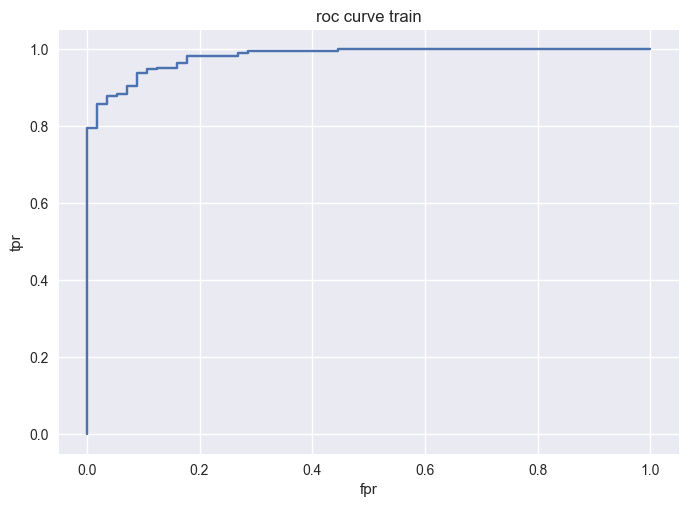

In [21]:
lr_threshold = 0.1
print('Precision/Recall: ')
print(classification_report(y1, (y1_pred>lr_threshold).astype(int)))

print('Accuracy: ')
print(accuracy_score(y1, (y1_pred>lr_threshold).astype(int)))

print('roc auc score: ')
print(roc_auc_score(y1, y1_pred))

print('Roc curve: ')
fpr, tpr, thresholds = roc_curve(y1, y1_pred)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve train')
plt.savefig(my_filename('roc_auc_train.png'), dpi=200)
plt.show()

Precision/Recall: 
              precision    recall  f1-score   support

           0       0.14      0.50      0.22         6
           1       0.91      0.62      0.74        48

    accuracy                           0.61        54
   macro avg       0.53      0.56      0.48        54
weighted avg       0.82      0.61      0.68        54

Accuracy: 
0.6111111111111112
roc auc score: 
0.6462585034013606
Roc curve: 


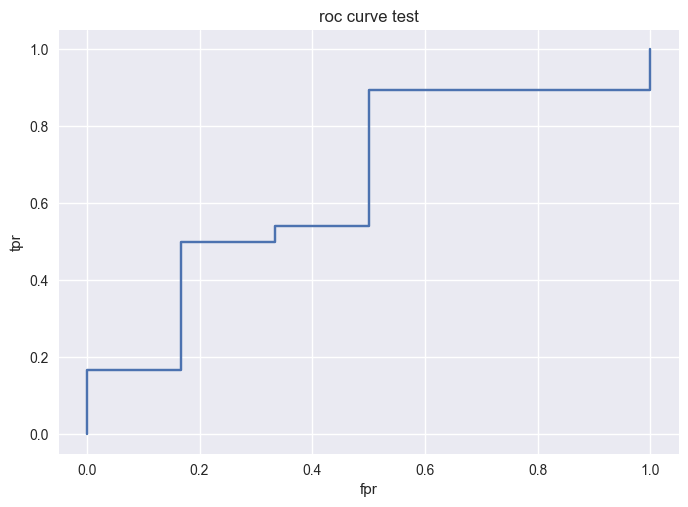

In [22]:
lr_threshold = 0.5
print('Precision/Recall: ')
print(classification_report(y2[:-1], (y2_pred>lr_threshold).astype(int)[:-1]))

print('Accuracy: ')
print(accuracy_score(y2[:-1], (y2_pred>lr_threshold).astype(int)[:-1]))

print('roc auc score: ')
print(roc_auc_score(y2, y2_pred))

print('Roc curve: ')
fpr, tpr, thresholds = roc_curve(y2[:-1], y2_pred[:-1])
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve test')
plt.savefig(my_filename('roc_auc_test.png'), dpi=200)
plt.show()

Precision/Recall: 
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         6
           1       0.92      0.75      0.83        48

    accuracy                           0.72        54
   macro avg       0.56      0.62      0.56        54
weighted avg       0.84      0.72      0.77        54

Accuracy: 
0.7222222222222222
roc auc score: 
0.6462585034013606
Roc curve: 


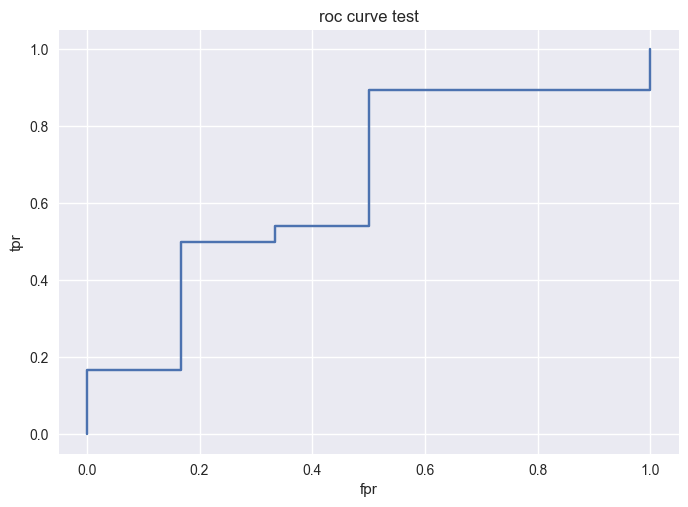

In [23]:
lr_threshold = 0.2
print('Precision/Recall: ')
print(classification_report(y2[:-1], (y2_pred>lr_threshold).astype(int)[:-1]))

print('Accuracy: ')
print(accuracy_score(y2[:-1], (y2_pred>lr_threshold).astype(int)[:-1]))

print('roc auc score: ')
print(roc_auc_score(y2, y2_pred))

print('Roc curve: ')
fpr, tpr, thresholds = roc_curve(y2[:-1], y2_pred[:-1])
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve test')
plt.savefig(my_filename('roc_auc_test.png'), dpi=200)
plt.show()

## visualization

In [24]:
import shap
from shap import TreeExplainer, Explainer

In [25]:
explainer = Explainer(clf, x2, feature_names=feature_names)

In [26]:
shap_values = explainer(x2)

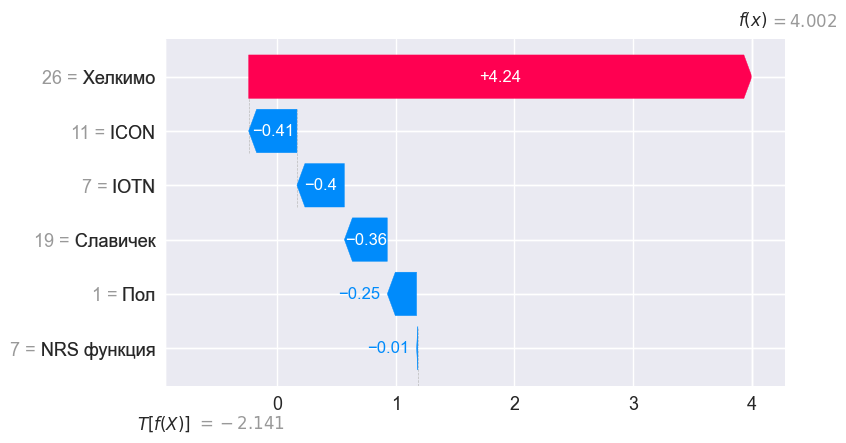

In [27]:
idx = 33
res = explainer(np.expand_dims(x2[idx], 0))
res.data = d2.loc[idx][feature_cols].values[None, :]

shap.plots.waterfall(res[0], show=True)
# plt.savefig(my_filename('img_1.png'), dpi=200, bbox_inches='tight')
# plt.show()

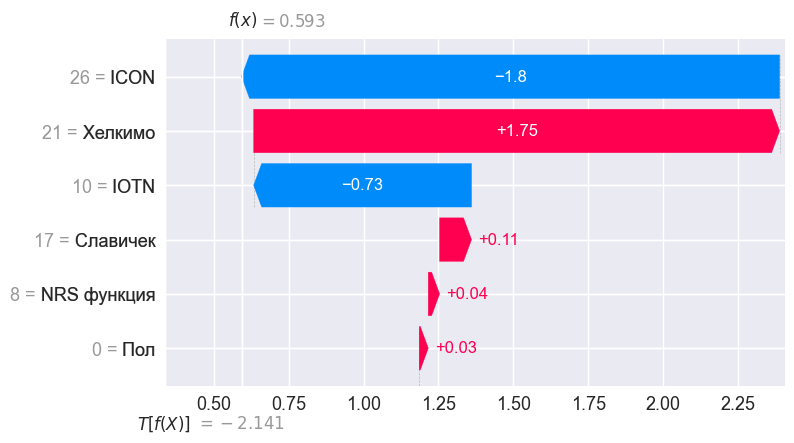

In [28]:
idx = 34
res = explainer(np.expand_dims(x2[idx], 0))
res.data = d2.loc[idx][feature_cols].values[None, :]

shap.plots.waterfall(res[0], show=True)
# plt.savefig(my_filename('img_2.png'), dpi=200, bbox_inches='tight')
# plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


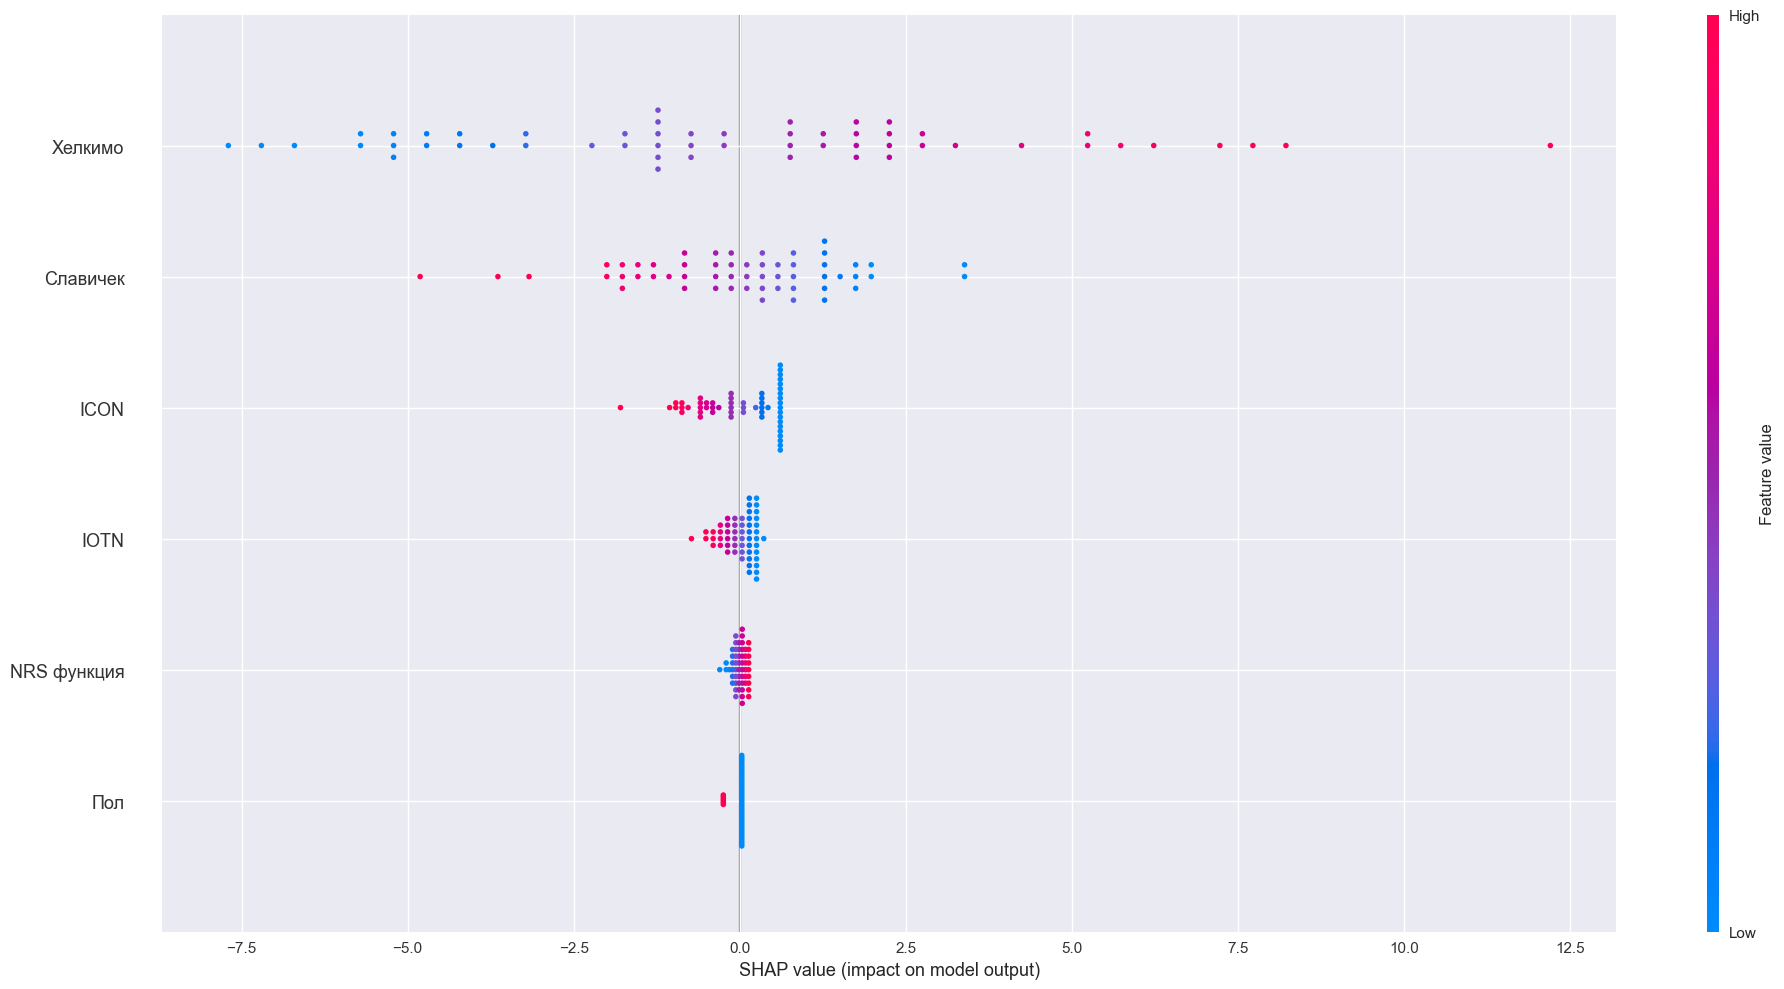

<Figure size 800x550 with 0 Axes>

In [29]:
shap.summary_plot(shap_values, plot_size=(20, 10), show=True)
plt.savefig(my_filename('img_main.png'), dpi=200)

## visual

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [31]:
d = pd.concat([d1, d2], ignore_index=True)

In [32]:
pca = PCA(n_components=2)
x = pca.fit_transform(d[cols])

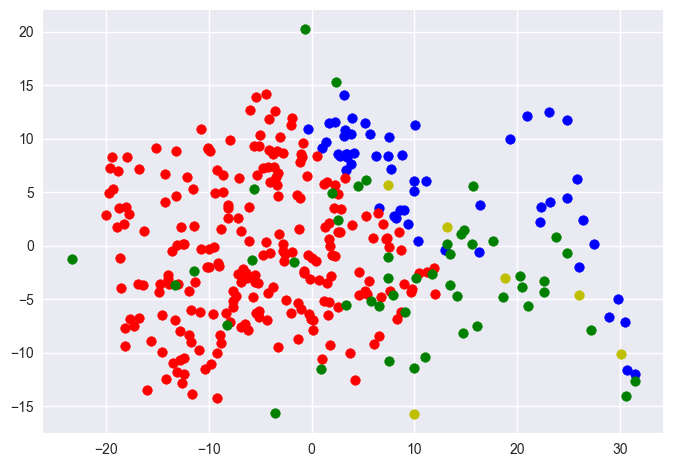

In [33]:
plt.scatter(x[d[(d['label']==1)&(d['_class']==0)].index.values, 0], 
            x[d[(d['label']==1)&(d['_class']==0)].index.values, 1], color='b')
plt.scatter(x[d[(d['label']==1)&(d['_class']==1)].index.values, 0], 
            x[d[(d['label']==1)&(d['_class']==1)].index.values, 1], color='r')

plt.scatter(x[d[(d['label']==2)&(d['_class']==0)].index.values, 0], 
            x[d[(d['label']==2)&(d['_class']==0)].index.values, 1], color='y')
plt.scatter(x[d[(d['label']==2)&(d['_class']==1)].index.values, 0], 
            x[d[(d['label']==2)&(d['_class']==1)].index.values, 1], color='g')

In [34]:
tsne = TSNE(n_components=2)
x = tsne.fit_transform(d[cols])

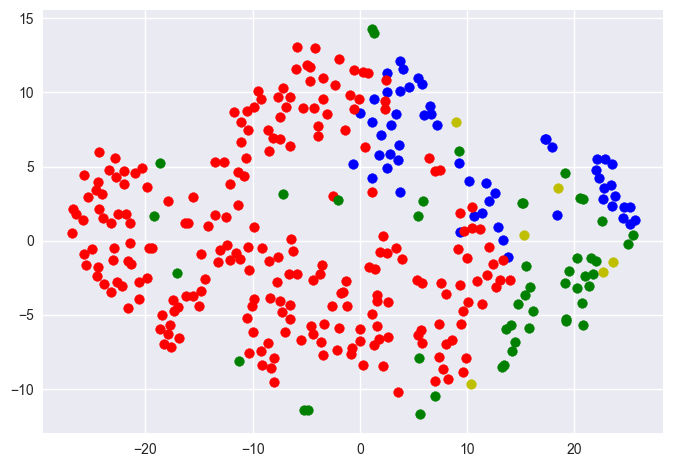

In [35]:
plt.scatter(x[d[(d['label']==1)&(d['_class']==0)].index.values, 0], 
            x[d[(d['label']==1)&(d['_class']==0)].index.values, 1], color='b')
plt.scatter(x[d[(d['label']==1)&(d['_class']==1)].index.values, 0], 
            x[d[(d['label']==1)&(d['_class']==1)].index.values, 1], color='r')

plt.scatter(x[d[(d['label']==2)&(d['_class']==0)].index.values, 0], 
            x[d[(d['label']==2)&(d['_class']==0)].index.values, 1], color='y')
plt.scatter(x[d[(d['label']==2)&(d['_class']==1)].index.values, 0], 
            x[d[(d['label']==2)&(d['_class']==1)].index.values, 1], color='g')